## HIV-1 ENV energy landscape
* Analysis of HIV-1 ENV encoding region from genome
* Data obtained from https://www.hiv.lanl.gov/content/sequence/NEWALIGN/align.html (3/23/2023)
    * Alignment type -- Filtered Web
    * Contain a subset of sequences from the web alignments. Typically 80-95% of the sequences in the corresponding Web Alignment are retained. The Filtered Alignments are cleaner, but contain less information. They are only available for HIV-1.
    * Excluded from the Filtered alignment:

        * Sequences with >1 frameshifts.
        * Sequences with >1% ambiguity codes in genome alignments.
        * Sequences with any ambiguity code that prevents translation of the codon in gene alignments.
        * Sequences with significant insertions or deletions (assessed by manual curation).



In [1]:
import os.path, sys
# Define path to utility code and insert it into jupyter path for import
path_to_utilities = '/data/cresswellclayec/ER_omic/utilities/'
sys.path.insert(0, path_to_utilities)

import numpy as np
import pandas as pd
from scipy import linalg
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder

import Bio.PDB, warnings
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
from scipy.spatial import distance_matrix
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

from joblib import Parallel, delayed
import timeit
# %matplotlib inline

import matplotlib.pyplot as plt

# # --- Import our Code ---# #
#import emachine as EM
from direct_info import direct_info

# import data processing and general DCA_ER tools
from data_processing import data_processing_msa2pdb
import tools
from pathlib import Path
np.random.seed(1)

from Bio import SeqIO
from Bio.PDB import *
from scipy.spatial import distance_matrix
from Bio import pairwise2
#from Bio.SubsMat.MatrixInfo import blosum62
pdb_parser = Bio.PDB.PDBParser()

from prody import *
import pickle


In [2]:
# Define data directories
line1_dir = '/data/cresswellclayec/ER_omic/energy_landscape/hiv'
data_dir = "%s/data" % line1_dir

In [3]:
# Load all HIV-1 ENV sequences
all_seqs = []
with open('%s/HIV1_REF_2020_env_DNA.fasta' % data_dir, 'rU') as f:
    seq_iter = SeqIO.parse(f,'fasta')
    for seq in seq_iter:
        all_seqs.append(seq)
        
# Get numpy array of HIV-1 ENV sequences
s0 = np.array([seq.seq for seq in all_seqs])
print(s0.shape)

(459, 3366)


In [4]:
# # codon mapping -- get protein sequence from nucleotide sequence
# from codon_mapping import translate_sequence
# # test
# seq = s0[0]
# indices = np.array([i for i in range(s0.shape[1])])
# subject_index = 0
# protein, index_mapping, index_tuple = translate_sequence(seq,indices,subject_index)

# Get one-hot encoding of all posible sequences
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
onehot_encoder.fit(s0)
s = onehot_encoder.transform(s0)


In [5]:
# Get PCA reduction of one-hot data in order to visualize as in the paper
from sklearn.decomposition import PCA
pca_dim=3
pca = PCA(n_components = pca_dim)
s_pca = pca.fit_transform(s)


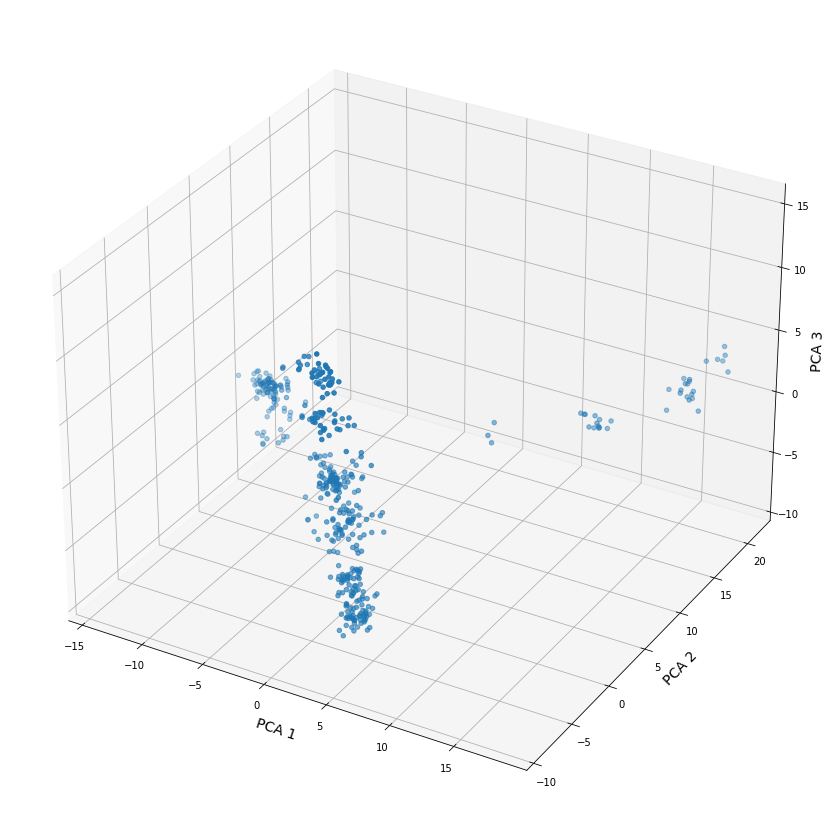

In [6]:
# Plot PCA and visualize evolution/transition of families
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

ax.scatter(s_pca[:,0], s_pca[:,1], s_pca[:,2])
ax.set_xlabel('PCA 1', fontsize=14)
ax.set_ylabel('PCA 2', fontsize=14)
ax.set_zlabel('PCA 3', fontsize=14)
plt.show()

(array([0, 1], dtype=int32), array([402,  57]))


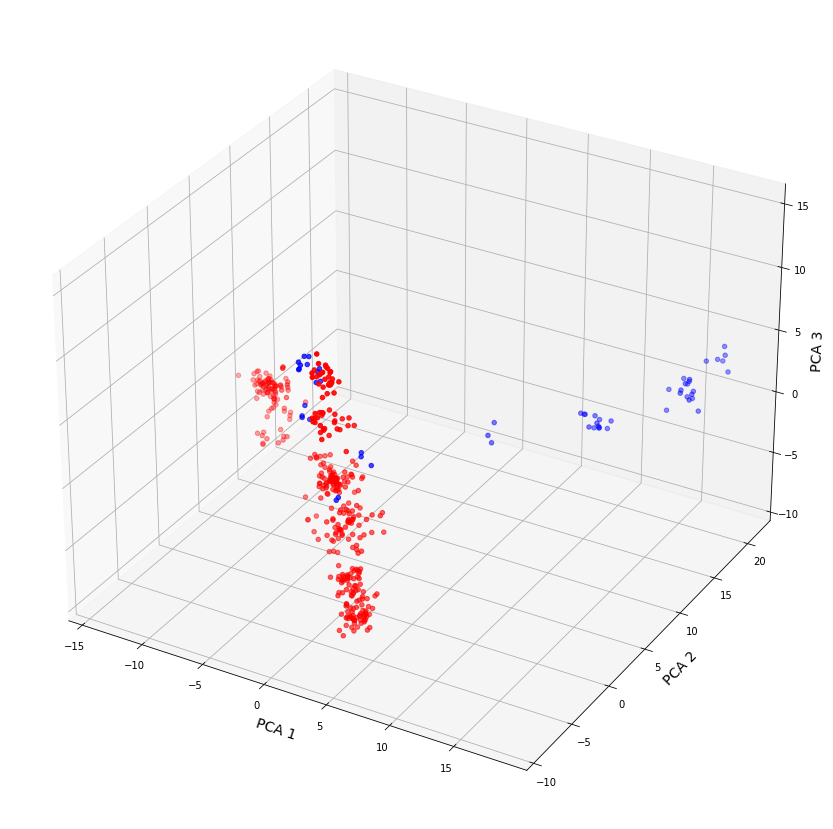

In [7]:
# Because there is no meta/family/group data, generate clusters and plot clusters with colors.
# Spectral Clustering of OneHot representation of MSA
# https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c

from sklearn.cluster import SpectralClustering
n_cluster = 2
if os.path.exists("%s/cov_env_%dcluster.pkl" % (data_dir, n_cluster)):
    with open("%s/cov_env_%dcluster.pkl" % (data_dir, n_cluster), "rb") as f:
        clustering = pickle.load(f)
    f.close()
else:
    clustering = SpectralClustering(n_clusters=n_cluster, random_state=0).fit(s_pca)
    # save 4 clustered omicron and delta.
    with open("%s/cov_env_%dcluster.pkl" % (data_dir, n_cluster), "wb") as f:
        pickle.dump(clustering,f )
    f.close()


# get color codes by cluster for spectral clusters
colors = ['r','b','g','y']
print(np.unique(clustering.labels_, return_counts=True))
cluster_colors = [colors[i] for i in clustering.labels_]
# Plot PCA and visualize evolution/transition of families
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

ax.scatter(s_pca[:,0], s_pca[:,1], s_pca[:,2], c=cluster_colors)
ax.set_xlabel('PCA 1', fontsize=14)
ax.set_ylabel('PCA 2', fontsize=14)
ax.set_zlabel('PCA 3', fontsize=14)

plt.show()

# get indices of each of the clusters
c_index = [np.array([i for i in clustering.labels_ if i == cluster_int ]) 
           for cluster_int in range(n_cluster)]
# get sequence set for each cluster
s_clusters = [s[c_ind] for c_ind in c_index]

## Generate w_ER
* Use expectation reflection to infer co-evolutionary relationship between sequence positions

In [8]:
# number of positions
n_var = s0.shape[1]
n_seq = s0.shape[0]

print("Number of residue positions:",n_var)
print("Number of sequences:",n_seq)

# number of aminoacids at each position
mx = np.array([len(np.unique(s0[:,i])) for i in range(n_var)])
print("Number of different amino acids at each position",mx)

# total number of onehot variables
mx_cumsum = np.insert(mx.cumsum(),0,0)
i1i2 = np.stack([mx_cumsum[:-1],mx_cumsum[1:]]).T
# print(\"(Sanity Check) Column indices of first and (\",i1i2[0],\") and last (\",i1i2[-1],\") positions\")
# print(\"(Sanity Check) Column indices of second and (\",i1i2[1],\") and second to last (\",i1i2[-2],\") positions\")

# number of variables
mx_sum = mx.sum()
print("Total number of variables",mx_sum)

# number of bias term
n_linear = mx_sum - n_var

Number of residue positions: 3366
Number of sequences: 459
Number of different amino acids at each position [2 3 1 ... 2 2 3]
Total number of variables 12635


In [ ]:
from joblib import Parallel, delayed                                                                     
import expectation_reflection as ER                                                                      
s_centered = s - s.mean(axis=0)      

for i,s_train in enumerate(s_clusters):
    print(s_train.shape)
    # Define w matrix with variable for each possible amino acid at each sequence position               
    w_ER = np.zeros((mx.sum(),mx.sum()))                                                                     
    h0 = np.zeros(mx.sum())             

    # Expectation Reflection                                                                                 
    #=========================================================================================#
    def predict_w(s,i0,i1i2,niter_max,l2):                                                                   
        #print('i0:',i0)                                                                                     
        i1,i2 = i1i2[i0,0],i1i2[i0,1]                                                                        
        x = np.hstack([s[:,:i1],s[:,i2:]])                                                                   
        y = s[:,i1:i2]                                                                                       
        h01,w1 = ER.fit(x,y,niter_max,l2)                                                                    
        return h01,w1                                                                                        


    w_file = "%s/cluster%d_w.npy" % (data_dir, i)   
    wsym_file = "%s/cluster%d_w_sym.npy" % (data_dir, i)   
    b_file = "%s/cluster%s_b.npy" % (data_dir, i)        

    create_new = False
    if os.path.exists(w_file) and not create_new:                                                          
        w_ER = np.load(w_file)      
        w_ER_sym = np.load(w_file)                                                                               
        b = np.load(b_file)                                                                               

    else:                                                                                                    
        #-------------------------------                                                                     
        # parallel                                                                                           
        start_time = timeit.default_timer()                                                                  
        res = Parallel(n_jobs = 20-2)(delayed(predict_w)                                                   
                (s_train,i0,i1i2,niter_max=10,l2=100.0)                                                          
                for i0 in range(n_var))

        run_time = timeit.default_timer() - start_time                                                       
        print('run time:',run_time)                                                                          
        #------------------------------- 
        for i0 in range(n_var):
            i1,i2 = i1i2[i0,0],i1i2[i0,1]                                                                    

            h01 = res[i0][0]                                                                                 
            w1 = res[i0][1]

            h0[i1:i2] = h01                                                                                  
            w_ER[:i1,i1:i2] = w1[:i1,:]                                                                      
            w_ER[i2:,i1:i2] = w1[i1:,:]                                                                      

        # make w symmetric                                                                                   
        w_ER_sym = (w_ER + w_ER.T)/2.            
        print(w_ER)
        print(w_ER_sym)
        b = h0

        np.save(w_file, w_ER)
        np.save(wsym_file, w_ER_sym)
        np.save(b_file, b)


(402, 12635)


In [ ]:
from er_energy import energy_diff
from scipy.spatial import distance



print('identity energy difference: ', energy_diff(i1i2,s_train[1,:], s_train[1,:], w_ER, b, return_pos_array=True))
print('seq 1 vs 2 energy difference: ', energy_diff(i1i2,s_train[1,:],s_train[2,:],w_ER, b))
print('seq 1 vs seq2 hamming distance: ', distance.squareform(distance.pdist(s_train[1:3,:], 'hamming')))
print(distance.squareform(distance.pdist([s_train[1,:],s_train[2,:]], 'hamming'))[0][1])

# Sequence Energy Difference in PCA-space
                   

In [ ]:
# Get W-er for all families
#    -- Allows us to calculate the sequence energy using different "sequence backgrounds"
w_families = []
w_sym_families = []
b_families = []
for msa_id in range(7):
    w_file = "%s/w_%s.npy" % (data_dir,lp_names[msa_id]) 
    w_sym_file = "%s/w_sym_%s.npy" % (data_dir,lp_names[msa_id]) 
    b_file = "%s/b_%s.npy" % (data_dir,lp_names[msa_id])        

    if os.path.exists(w_file):
#     if 0:
        w_fam = np.load(w_file)
        w_sym_fam = np.load(w_sym_file)
        b_fam = np.load(b_file)
    else:
        w_fam = np.zeros((mx.sum(),mx.sum()))                                                                     
        h0 = np.zeros(mx.sum()) 
            #-------------------------------                                                                     
        # parallel  
        s_msa = s_train[family_indx[msa_id]]
        start_time = timeit.default_timer()                                                                  
        res = Parallel(n_jobs = 20-2)(delayed(predict_w)                                                   
                (s_msa,i0,i1i2,niter_max=10,l2=100.0)                                                          
                for i0 in range(n_var))                                                                      

        run_time = timeit.default_timer() - start_time                                                       
        print('family %d run time:' %msa_id ,run_time)                                                                          
        #------------------------------- 
        for i0 in range(n_var):
            i1,i2 = i1i2[i0,0],i1i2[i0,1]                                                                    

            h01 = res[i0][0]                                                                                 
            w1 = res[i0][1]

            h0[i1:i2] = h01                                                                                  
            w_fam[:i1,i1:i2] = w1[:i1,:]                                                                      
            w_fam[i2:,i1:i2] = w1[i1:,:]                                                                      

        # make w symmetric     
        b_fam = h01
        w_sym_fam = (w_fam + w_fam.T)/2.   
        np.save(b_file, b_fam)
        np.save(w_sym_file, w_sym_fam)
        np.save(w_file, w_fam)

    b_families.append(h0)
    w_families.append(w_fam)
    w_sym_families.append(w_sym_fam)

In [ ]:
# Calulate sequence energy of all sequences from the perspective of different 
# "sequence backgrounds"
if not os.path.exists('%s/gp0_SvsAVG_energy.npy'%data_dir):
    s_E_rows = []
    for msa_indx, w_fam in enumerate(w_families):
        b_fam = b_families[msa_indx]
        w_fam = w_families[msa_indx]
        gp_mean = np.mean(s[family_indx[msa_indx]], axis=0)
        s_E_row = np.zeros(len(full_s))
        print(energy_diff(i1i2,gp_mean,full_s[0,:],w_fam,b_fam))
        # serial energy computation
#         s_E_row = []
#         for seq in full_s:
#             s_E_row.append(np.array(energy_diff(i1i2,gp_mean,seq,w_fam,b_fam)))
#         s_E_row = np.array(s_E_row)
#         s_E_rows.append(s_E_row)
        # parallel energy computation
        res = Parallel(n_jobs = 20-2)(delayed(energy_diff)
                (i1i2,gp_mean,full_s[i0,:],w_fam,b_fam)
                for i0 in range(len(full_s)))
        s_E_row = np.array(res)
        print(s_E_row.shape)
        s_E_rows.append(s_E_row)
        np.save('%s/gp%d_SvsAVG_energy.npy' % (data_dir,msa_indx), s_E_row)
else:
    s_E_rows = []
    for i in range(len(gps)):
        s_E_rows.append(np.load('%s/gp%d_SvsAVG_energy.npy' % (data_dir, i)))
    print(s_E_rows)
    s_E_row = s_E_rows[msa_1]

In [ ]:
# PCA space contours.
from sklearn.decomposition import PCA
msa_1 = 2
msa_2 = msa_1+1
indx_12 = np.concatenate((family_indx[msa_1],family_indx[msa_2]))

pca = PCA(n_components=2).fit(s[indx_12])                                                                         
pca_s = pca.transform(s)
print('original sequences shape: ', s_train.shape)                                                   
print('pca-embed: ', pca.components_.shape)                                                          


In [ ]:
from scipy.ndimage.filters import gaussian_filter
import matplotlib.tri as tri                                                                                                     

x = pca_s[indx_12,0]
y = pca_s[indx_12,1]
z = s_E_rows[msa_1][indx_12]

fig = plt.figure(figsize=(15,10))
ax  = fig.add_subplot(111)

gp1_mean = np.mean(pca_s[family_indx[msa_1]], axis=0)

# Create grid values first.
ngridx = 200
ngridy = 200
xi = np.linspace(min(x)-1, max(x)+1, ngridx)
yi = np.linspace(min(y)-1, max(y)+1, ngridy)

# Perform linear interpolation of the data (x,y)
triang = tri.Triangulation(x, y)
interpolator = tri.LinearTriInterpolator(triang, z)

Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)
Zi = gaussian_filter(zi, sigma=2.)

ax.contour(Xi, Yi, Zi, levels=10, linewidths=0.5, colors='k')
cntr1 = ax.contourf(Xi, Yi, Zi, levels=10, cmap="RdBu_r")
                                                                              

ax.scatter(pca_s[family_indx[msa_1],0], pca_s[family_indx[msa_1],1], color=colors[msa_1], label=lp_names[msa_1])  
ax.scatter(pca_s[family_indx[msa_2],0], pca_s[family_indx[msa_2],1], color=colors[msa_2], label=lp_names[msa_2])                                                                               

ax.scatter(gp1_mean[0], gp1_mean[1], marker='*',color=colors[msa_1],s=100)
plt.legend()
plt.title('Landscape using energy difference with %s-mean sequence'%lp_names[msa_1])
plt.show()